In [34]:
import rl.environments
from os.path import join
from stable_baselines import PPO2
from stable_baselines.common.vec_env import DummyVecEnv
import yaml, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = pathlib.Path().absolute()

# ## different designs, with imi, with diff reward structure
# to_combine=[
#    ['ConveyorEnv1', '20210111_0000'],        #2x2
#     ['ConveyorEnv1','20210111_0100'],         #2x3
#     ['ConveyorEnv1','20210111_0200'],         #3x3
#     ['ConveyorEnv1','20210111_0300'],       #4x3
#     ['ConveyorEnv1','20210111_0400'],
#     ['ConveyorEnv1','20210111_0500']            # 5x3
# ]

#for the different designs without imitation learning upfront
# to_combine=[
#     ['ConveyorEnv1','20210109_1900'], #1x2
#     ['ConveyorEnv1','20210109_2000'], #2x2
#     ['ConveyorEnv1','20210109_2100'], #2x3
#     ['ConveyorEnv1','20210109_2200'], #3x32
#     ['ConveyorEnv1','20210109_2300'], #4x3
#     ['ConveyorEnv1','20210109_2400']  #5x3
# ]

#  different designs, reward structure with punishment on terminate
to_combine=[
    ['ConveyorEnv12','20210112_0100'], #1x2
    ['ConveyorEnv12','20210112_0200'], #2x2
    ['ConveyorEnv12','20210112_0300'], #2x3
    ['ConveyorEnv12','20210112_0400'], #3x32
    ['ConveyorEnv12','20210112_0500'], #4x3
    #['ConveyorEnv12','20210112_1000'], #4x3
    #['ConveyorEnv12','20210112_1100'],  #5x3
    ['ConveyorEnv12','20210112_1200'], #4x3
    ['ConveyorEnv12','20210112_1300'],  #5x3
    ['ConveyorEnv12','20210112_1400'],  #5x3
    ['ConveyorEnv12','20210112_1430']
]

## For the buffer size
# to_combine=[
#     ['ConveyorEnv11','20210108_1400'], #1
#     ['ConveyorEnv11','20210108_1500'], #2
#     ['ConveyorEnv11','20210108_1600'], #3
#     ['ConveyorEnv11','20210108_1700'], #4
#     ['ConveyorEnv11','20210108_1800'], #5
#     ['ConveyorEnv11','20210108_1900'], #6
#     ['ConveyorEnv11','20210108_2000'], #7
#     ['ConveyorEnv11','20210108_2100'], #8
#     ['ConveyorEnv11','20210108_2200'], #9
#     ['ConveyorEnv11','20210108_2300'] #10
    
# ]

# For the pipeline
# to_combine=[
#     ['ConveyorEnv11','20210109_1000'], #10
#     ['ConveyorEnv11','20210109_1100'], #15
#     ['ConveyorEnv11','20210109_1200'], #20
#     ['ConveyorEnv11','20210109_1300'], #25
#     ['ConveyorEnv11','20210109_1400'], #30
#     ['ConveyorEnv11','20210109_1500'], #35
#     ['ConveyorEnv11','20210109_1800'], #40
#     ['ConveyorEnv11','20210109_1900'], #45
#     ['ConveyorEnv11','20210109_2000'] #50
# ]

In [35]:
env1, subdir = to_combine[0]
episodes = 100
#combinations = ['2x2', '2x2_pretrained', '2x2_sto', '2x2_sto_gamma_adjust', '2x2_sto_only_punish', '2x2_sto_only_punish_lowerR']
#combinations = ['1x2', '2x2', '2x3', '3x3', '4x3', '5x3']
combinations = [item[1] for item in to_combine]
#combinations = ['buffersize_{:02d}'.format(i+1) for i in range(11)]
#combinations = ['pipeline_{}'.format(i) for i in range(10,55,5)]

results = {}
for idx, combination in enumerate(to_combine):
    env1, subdir = combination
    # load config and variables needed
    location_path= join(path, 'rl', 'trained_models', env1, subdir)
    with open(join(location_path, 'config.yml'), 'r') as c:
        config = yaml.load(c)
        print('\nLoaded config file from: {}\n'.format(join(location_path, 'config.yml')))
    model_config = config['models']['PPO2']

    #initialize env with the config file
    env_obj = getattr(rl.environments, env1)
    env = env_obj(config)
 

    # load best model from path
    model = PPO2.load(join(location_path, 'best_model.zip'), env=DummyVecEnv([lambda: env]))


    results[combinations[idx]] = {}
    results[combinations[idx]]['configuration'] = '{}x{}'.format(config['environment']['amount_of_gtps'], config['environment']['amount_of_outputs'])
    results[combinations[idx]]['gamma'] = config['models']['PPO2']['gamma']
    results[combinations[idx]]['idle_time'] = 0
    results[combinations[idx]]['cycle_count'] = 0
    results[combinations[idx]]['steps'] = 0
    results[combinations[idx]]['items_processed'] = 0
    results[combinations[idx]]['reward'] = 0

    for episode in range(episodes):
        # Run an episode
        state = env.reset()
        done = False
        while not done:
            action, _ = model.predict(state, deterministic=True)
            state, reward, done, tc = env.step(action)
            results[combinations[idx]]['reward'] += reward
        results[combinations[idx]]['idle_time'] += sum(env.idle_times_operator.values())
        results[combinations[idx]]['cycle_count'] += env.cycle_count
        results[combinations[idx]]['steps'] += env.steps
        results[combinations[idx]]['items_processed'] += env.items_processed
        
    results[combinations[idx]]['idle_time'] = results[combinations[idx]]['idle_time'] / episodes
    results[combinations[idx]]['cycle_count'] = results[combinations[idx]]['cycle_count'] /episodes
    results[combinations[idx]]['steps'] = results[combinations[idx]]['steps'] /episodes
    results[combinations[idx]]['items_processed'] = results[combinations[idx]]['items_processed'] /episodes
    results[combinations[idx]]['reward'] = results[combinations[idx]]['reward'] /episodes

D:\Drive\git\venv\fresh\lib\site-packages\ipykernel_launcher.py:15: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.




Loaded config file from: D:\Drive\git\RL\rl\trained_models\ConveyorEnv12\20210112_0100\config.yml



D:\Drive\git\venv\fresh\lib\site-packages\ipykernel_launcher.py:15: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.




Loaded config file from: D:\Drive\git\RL\rl\trained_models\ConveyorEnv12\20210112_0200\config.yml



Ep:   100, steps:  94, R: 18.000
Loaded config file from: D:\Drive\git\RL\rl\trained_models\ConveyorEnv12\20210112_0300\config.yml



D:\Drive\git\venv\fresh\lib\site-packages\ipykernel_launcher.py:15: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



Ep:   100, steps: 118, R: 33.000
Loaded config file from: D:\Drive\git\RL\rl\trained_models\ConveyorEnv12\20210112_0400\config.yml



D:\Drive\git\venv\fresh\lib\site-packages\ipykernel_launcher.py:15: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



D:\Drive\git\venv\fresh\lib\site-packages\ipykernel_launcher.py:15: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.




Loaded config file from: D:\Drive\git\RL\rl\trained_models\ConveyorEnv12\20210112_0500\config.yml



D:\Drive\git\venv\fresh\lib\site-packages\ipykernel_launcher.py:15: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.




Loaded config file from: D:\Drive\git\RL\rl\trained_models\ConveyorEnv12\20210112_1200\config.yml



D:\Drive\git\venv\fresh\lib\site-packages\ipykernel_launcher.py:15: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.




Loaded config file from: D:\Drive\git\RL\rl\trained_models\ConveyorEnv12\20210112_1300\config.yml



Ep:   100, steps:  51, R: -78.0000
Loaded config file from: D:\Drive\git\RL\rl\trained_models\ConveyorEnv12\20210112_1400\config.yml



D:\Drive\git\venv\fresh\lib\site-packages\ipykernel_launcher.py:15: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



D:\Drive\git\venv\fresh\lib\site-packages\ipykernel_launcher.py:15: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.




Loaded config file from: D:\Drive\git\RL\rl\trained_models\ConveyorEnv12\20210112_1430\config.yml



In [42]:
resultcsv = pd.DataFrame.from_dict(results).T
#resultcsv = resultcsv.sort_index(ascending=False)
#resultcsv.to_csv('evaluation_results/results_DRL_pipe.csv')
#resultcsv.to_csv('evaluation_results/results_DRL_without_imit.csv')
#resultcsv.to_csv('evaluation_results/results_DRL_buffer.csv')
resultcsv['idle_percent'] = resultcsv.idle_time/resultcsv.steps 
#resultcsv['orders_processed'] = [50, 150, 150,250,350, 450]
resultcsv['cycle_percent'] = resultcsv.cycle_count/resultcsv.items_processed 
#resultcsv = resultcsv.reset_index()
resultcsv

,configuration,gamma,idle_time,cycle_count,steps,items_processed,reward,idle_percent,cycle_percent
20210112_0100,2x3,0.99375,1,0,136.34,7.06,15.18,0.0073346,0
20210112_0200,3x3,0.99375,1,0,114.66,9.14,21.42,0.00872144,0
20210112_0300,4x3,0.99375,1.01,0,107.01,11.32,27.96,0.00943837,0
20210112_0400,5x3,0.99375,1.02,0.46,103.68,13.41,32.85,0.00983796,0.0343028
20210112_0500,2x2,0.99375,0.09,6.1,1429.3,151.06,444.93,6.29679e-05,0.0403813
20210112_1200,2x2,0.99375,0.04,5.79,1411.73,147.08,434.82,2.8334e-05,0.0393663
20210112_1300,2x2,0.999,0.12,30.46,50.17,4.71,-83.22,0.00239187,6.46709
20210112_1400,3x3,0.99375,1,4.65,171.46,14.05,7.14,0.00583226,0.330961
20210112_1430,2x2,0.99,0.03,7.78,1410.48,147.81,429.87,2.12694e-05,0.0526351


In [43]:
resultcsv.to_excel('evaluation_results/results_DRL_term.xlsx')

ModuleNotFoundError: No module named 'openpyxl'

In [23]:
resultcsv = pd.DataFrame.from_dict(results).T
#resultcsv = resultcsv.sort_index(ascending=False)
#resultcsv.to_csv('evaluation_results/results_DRL_pipe.csv')
#resultcsv.to_csv('evaluation_results/results_DRL_without_imit.csv')
#resultcsv.to_csv('evaluation_results/results_DRL_buffer.csv')
#resultcsv['idle_percent'] = resultcsv.idle_time/resultcsv.steps * 100
#resultcsv['orders_processed'] = [50, 150, 150,250,350, 450]
#resultcsv['cycle_percent'] = resultcsv.cycle_count/resultcsv.orders_processed * 100
#resultcsv = resultcsv.reset_index()
resultcsv

,configuration,gamma,idle_time,cycle_count,steps,items_processed
20210112_0500,2x2,0.99375,0.02,5.98,1445.19,151.01
20210112_1200,2x2,0.99375,0.01,6.2,1421.1,149.58
20210112_1300,2x2,0.999,0.17,29.85,49.59,4.51
20210112_1400,3x3,0.99375,2828.3,401,1596.08,56.4


In [43]:
## From the buffer size comparedv.fokker
resultcsv = pd.DataFrame.from_dict(results).T
resultcsv.to_csv('evaluation_results/results_DRL_buffer.csv')
#resultcsv['idle_percent'] = resultcsv.idle_time/resultcsv.steps * 100
#resultcsv['orders_processed'] = [50, 150, 150,250,350, 450]
#resultcsv['cycle_percent'] = resultcsv.cycle_count/resultcsv.orders_processed * 100
#resultcsv = resultcsv.reset_index()
resultcsv

,idle_time,cycle_count,steps,items_processed
buffersize_1,161.13,155.39,1527.55,151.02
buffersize_2,183.34,125.95,1521.66,151.02
buffersize_3,39.03,42.35,1460.88,151.03
buffersize_4,3.82,1.53,1424.48,151.02
buffersize_5,16.85,4.78,1442.42,151.04
buffersize_6,0.33,0.57,1430.71,151.04
buffersize_7,0.00,2.88,1436.79,151.03
buffersize_8,0.02,2.34,1423.12,151.04
buffersize_9,0.00,0.55,1444.86,151.01
buffersize_10,0.00,0.78,1442.44,151.01


4000.0

# queue occupation

In [22]:
env1, subdir = to_combine[0]
episodes = 10
#combinations = ['1x2', '2x2', '2x3', '3x3', '4x3', '5x3']

to_combine=[
    ['AbstractConveyor2','20201217_1400'],
    ['AbstractConveyor2','20201217_1500'],
    ['AbstractConveyor2','20201217_1600'],
    ['AbstractConveyor2','20201217_1700'],
    ['AbstractConveyor2','20201217_1800'],
    ['AbstractConveyor2','20201217_1900'],
    ['AbstractConveyor2','20201217_2000'],
    ['AbstractConveyor2','20201217_2100'],
    ['AbstractConveyor2','20201217_2200'],
    ['AbstractConveyor2','20201217_2300']
    
]

results = {}
for idx, combination in enumerate(to_combine):
    env1, subdir = combination
    # load config and variables needed
    location_path= join(path, 'rl', 'trained_models', env1, subdir)
    with open(join(location_path, 'config.yml'), 'r') as c:
        config = yaml.load(c)
        print('\nLoaded config file from: {}\n'.format(join(location_path, 'config.yml')))
    model_config = config['models']['PPO2']

    #initialize env with the config file
    env_obj = getattr(rl.environments, env1)
    env = env_obj(config)

    # load best model from path
    model = PPO2.load(join(location_path, 'model.zip'), env=DummyVecEnv([lambda: env]))




    log_data=[]
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action, _ = model.predict(state, deterministic=False)
            state, reward, done, tc = env.step(action)
            log_data.append(env.len_queues)
    log_dataframe = pd.DataFrame(np.array(log_data)).reset_index()
    for i in range(env.amount_of_gtps):
        print('mean: ', log_dataframe[i].mean(), 'std: ', log_dataframe[i].std())

    labels = ['Queue 1', 'Queue 2', 'Queue 3', 'Queue 4', 'Queue 5']
    plt.boxplot([log_dataframe[i] for i in range(env.amount_of_gtps)], notch=True, labels=[label for label in labels][:env.amount_of_gtps], showfliers=False)
    plt.ylim(0,1)
    plt.ylabel('Queue occupation %')
    plt.xlabel('Queue number')
    plt.title('Occupation of queues for a {}x{} design'.format(env.amount_of_gtps, env.amount_of_outputs))
    plt.savefig('figures/box_rl_queues_{}x{}.png'.format(env.amount_of_gtps, env.amount_of_outputs))
    plt.show()
  


Loaded config file from: D:\Drive\git\RL\rl\trained_models\AbstractConveyor2\20201217_1400\config.yml



c:\users\_vinc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


AttributeError: module 'rl.environments' has no attribute 'AbstractConveyor2'

In [40]:
self.diverter_locations[workstation][0]

20

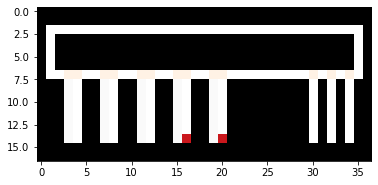

In [38]:
env.render_plt()

In [12]:
def get_env_type(env_name):
    """
    Get the type of environment from the env_name string
    """
    try:
        env = gym.make(env_name)
        del env
        return 'gym'
    except:
        return 'rl'

In [14]:
def make_rl(**kwargs):
    """
    Decorator for custom RL environments
    """
    def _init():
        env_obj = getattr(rl.environments, env_name)
        env = env_obj(config)
        return env
    return _init

def make_gym(rank, seed=0, **kwargs):
    """
    Decorator for gym environments
    """
    def _init():
        env = gym.make(env_name)
        env.seed(seed + rank)
        return env
    return _init

In [30]:
env_name = 'ConveyorEnv'
n_workers = 8
env_obj = getattr(rl.environments, env_name)
env = env_obj(config)

# multiprocess environment
env8 = [env for _ in range(n_workers)]

In [32]:
from rl.baselines.Wrapper import create_env

INFO:tensorflow:TensorFlow


In [34]:
env8 = create_env(env_name, config=config, n_workers=8)

In [35]:
env8